# Use of foscat to synthesise a global map from ONE target

This notebook has been based on Mouset et al 2024...

## Installation of required packages

In [1]:
!pip install foscat==3.0.44

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import foscat.scat_cov as sc
import foscat.Synthesis as synthe

### Choose the resolution

explain healpix here...
explain that input data are not yet design more than 128

In [3]:
nside=64

### Get LSS data
explain LSS

In [4]:
!wget -O target_map_lss.npy https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy

--2024-07-23 15:40:04--  https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astro-informatics/s2scat/main/notebooks/data/target_map_lss.npy [following]
--2024-07-23 15:40:04--  https://raw.githubusercontent.com/astro-informatics/s2scat/main/notebooks/data/target_map_lss.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::1

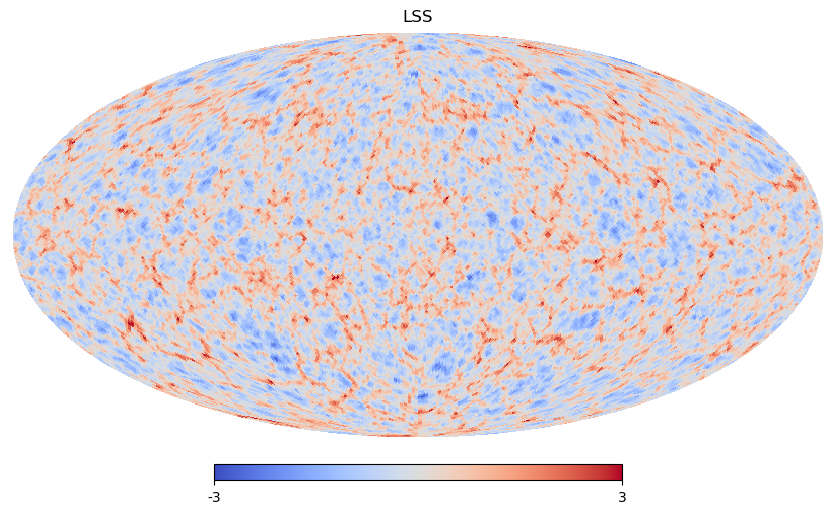

In [5]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=128 healpix map
l_nside=128

im = np.load('target_map_lss.npy')
xsize,ysize=im.shape

# Define the new row and column to be added to prepare the interpolation
new_row = im[0:1,:]  # A new row with N elements (the other longitude)
new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

# Add the new row to the array
im = np.vstack([im, new_row])

# Add the new column to the array with the new row

im = np.hstack([im, new_column])

# Create a grid of coordinates corresponding to the array indices
x = np.linspace(0, im.shape[0]-1, im.shape[0])
y = np.linspace(0, im.shape[1]-1, im.shape[1])

# Create an interpolator
interpolator = RegularGridInterpolator((x, y), im)

# List of healpix coordinate to interpol
colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
coords = np.concatenate([colatitude/np.pi*xsize,longitude/(2*np.pi)*ysize],0).reshape(2,colatitude.shape[0]).T

# Perform the interpolation
heal_im = interpolator(coords)

#reduce the final map to the expected resolution
if nside>128:
    th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
    heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
else:
    heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)
hp.mollview(heal_im,cmap='coolwarm',nest=True,title='LSS',min=-3,max=3)

# free memory
del coords
del interpolator
del colatitude
del longitude

### Initialise FOSCAT scattering covariance description

In [6]:
scat_op=sc.funct(NORIENT=4,          # define the number of wavelet orientation
                KERNELSZ=3,  #KERNELSZ,  # define the kernel size
                JmaxDelta=0,        # The used Jmax is Jmax-JmaxDelta
                all_type='float64')

          START FOSCAT CONFIGURATION


2024-07-23 15:40:09.491082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : /device:GPU:0                          ==
==                                                        ==
==                                                        ==
Init Wave  2
Init Wave  4
Init Wave  8
Init Wave  16
Init Wave  32


2024-07-23 15:40:12.343875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4118 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:30:00.0, compute capability: 8.0


### Compute the reference statistics

In [7]:
ref,sref=scat_op.eval(heal_im,calc_var=True)

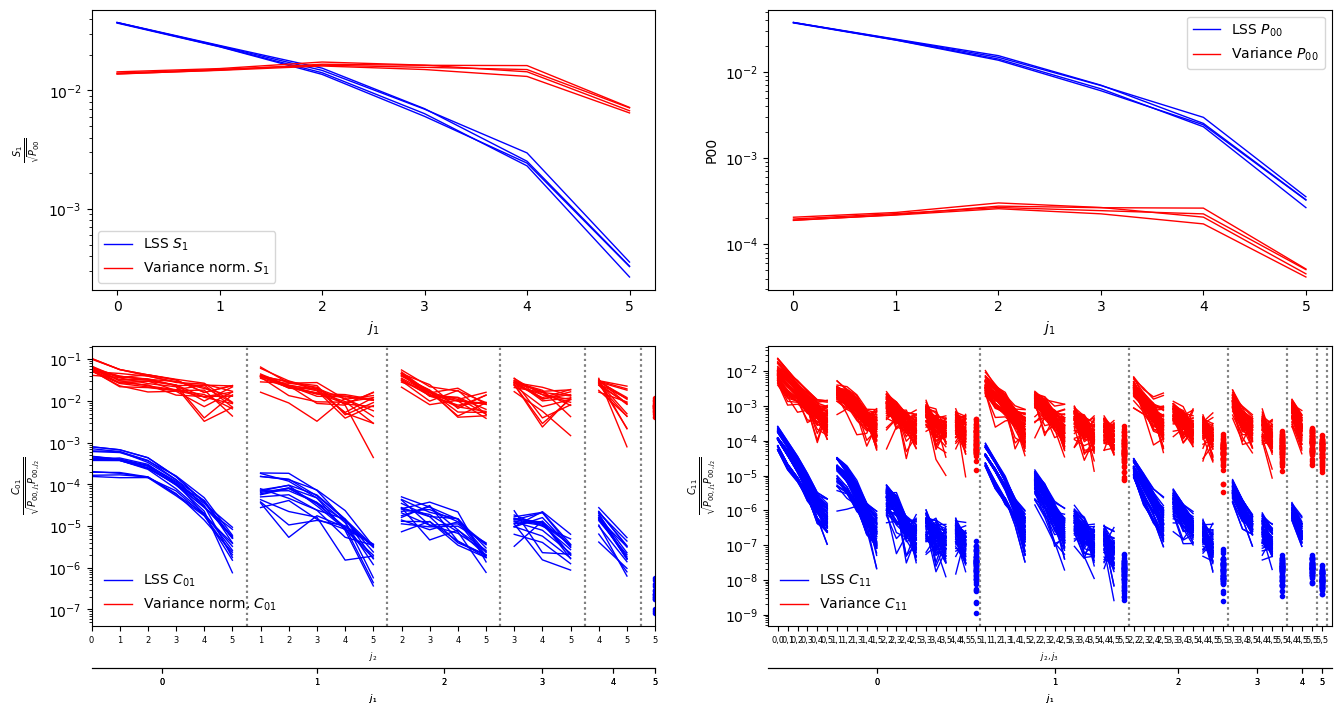

In [8]:
ref.plot(name='LSS',color='b')
sref.plot(name='Variance',color='r',hold=False)

### Define the loss function

In [9]:
def The_loss(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(u)

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

### Build the synthesis model

In [10]:
loss1=synthe.Loss(The_loss,scat_op,ref,sref)

sy = synthe.Synthesis([loss1])

### Run the synthesis

In [11]:
imap=np.random.randn(12*nside**2)*np.std(heal_im)
inscat=scat_op.eval(imap)

omap=sy.run(imap,
            EVAL_FREQUENCY=100,
            NUM_EPOCHS = 1000).numpy()

Total number of loss  1
 Run [PROC=0000] on GPU /device:GPU:0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Itt      0 L=  4.49e+03 (  4.49e+03 ) 37.124s 
Itt    100 L=      1.89 (      1.89 ) 10.458s 
Itt    200 L=     0.854 (     0.854 ) 11.341s 
Itt    300 L=     0.604 (     0.604 ) 11.284s 
Itt    4

### Plot the results

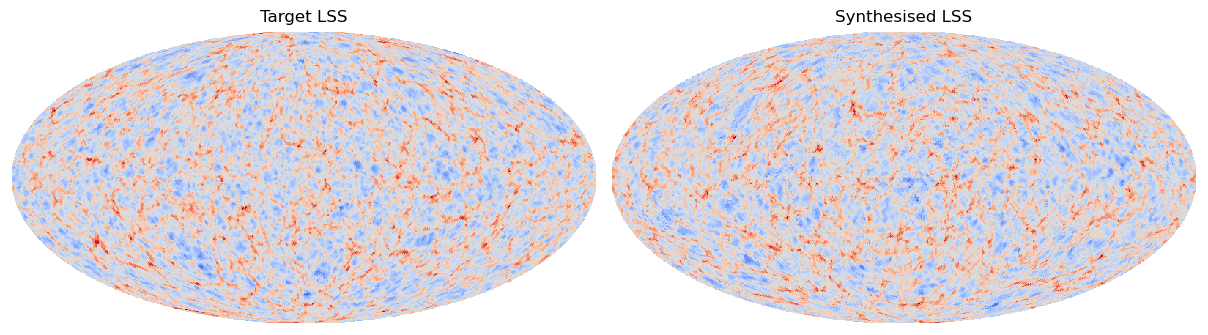

In [12]:
plt.figure(figsize=(12,5))
hp.mollview(heal_im,cmap='coolwarm',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(1,2,1),cbar=False)
hp.mollview(omap,cmap='coolwarm',nest=True,title='Synthesised LSS',min=-3,max=3,
            hold=False,sub=(1,2,2),cbar=False)


/srv/conda/envs/notebook/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


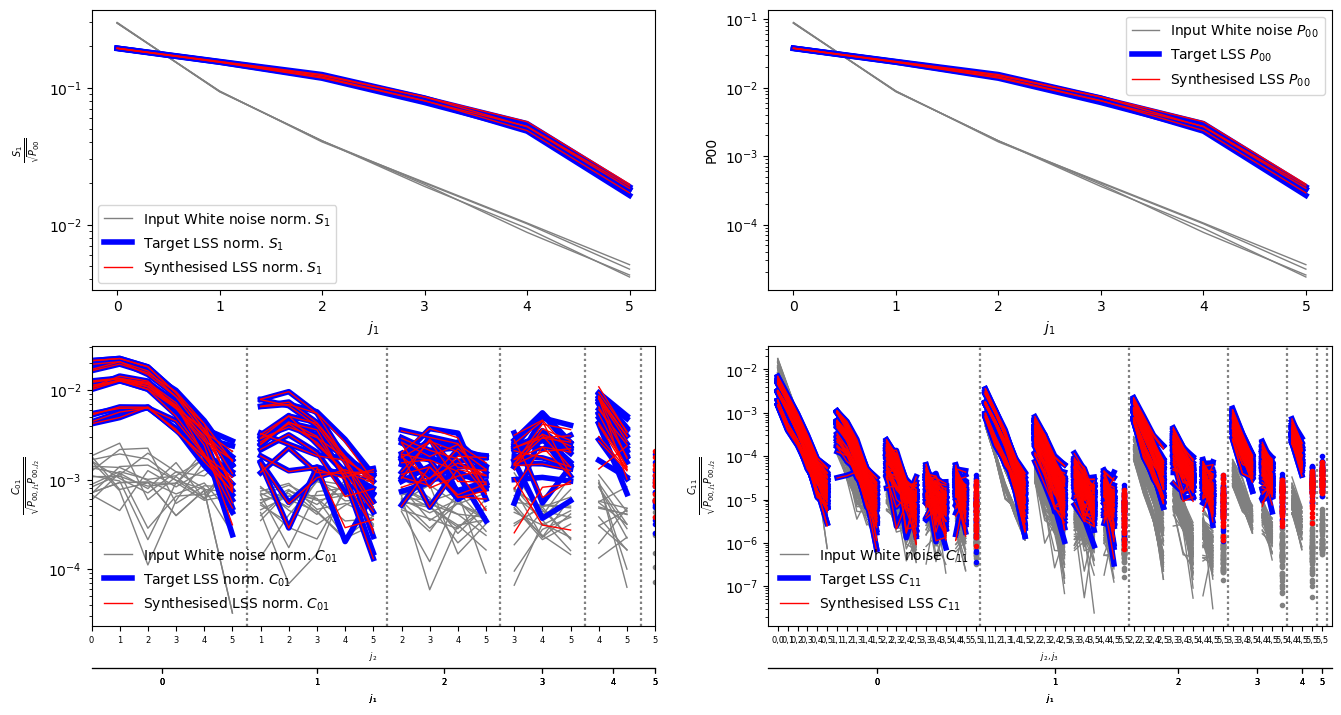

In [13]:
synth=scat_op.eval(omap)
inscat=scat_op.eval(imap)
inscat.plot(name='Input White noise',color='grey',norm=True)
ref.plot(name='Target LSS',color='b',norm=True,lw=4,hold=False)
synth.plot(name='Synthesised LSS',color='r',hold=False,norm=True)